In [315]:
from pyradiosky import SkyModel, utils
import numpy as np
from astropy.table import Table, setdiff, QTable
from astropy.utils.diff import report_diff_values
from astropy.io import fits
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import psutil
import erfa
import csv
sm = SkyModel()

ruby_catalog = sm.from_fhd_catalog("/Users/Kiana1/uwradcos/FHD/catalog_data/GLEAM_v2_plus_rlb2019.sav",
                                  expand_extended = True)
gleam_catalog = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "subband", with_error = True)
gleam_spectral_index = sm.from_gleam_catalog("/Users/Kiana1/uwradcos/gleam.vot", spectral_type = "spectral_index", with_error = True)

In [120]:
gleam_spectral_index.reference_frequency.value[10]

200000000.0

In [320]:
def log_linear_fit(freqs, fit_data, stokes_error, dec):
    ## Compute combined error, fit logged data to linear polynomial, calculate chi2 residual
    # Calculate coord-based portion of error
    if (dec >= 18.5) or (dec <= -72):
        loc_error = fit_data * .03
    else:
        loc_error = fit_data * .02
    
    # Compute total error and weight for the polyfit
    total_error = np.sqrt(loc_error**2 + stokes_error**2)
    weight = np.log10(1 / total_error)
    
    # Take logs of data and freqs for polyfit
    fit_data_log = np.log10(fit_data)
    freqs_log = np.log10(freqs)
    all_freqs_log = np.log10(gleam_catalog.freq_array.value)
    
    # Subset to freqs with no nans in vals or errors and do polyfit on only those freqs
    idx = np.isfinite(freqs_log) & np.isfinite(fit_data_log) & np.isfinite(weight)
    # coeffs is a pair of numbers (b, m) corresponding to the equation y=b+mx
    coeffs, extras = poly.polyfit(freqs_log[idx], fit_data_log[idx], w = weight[idx], deg=1, full=True)
    
    #print(extras)
    # Use coeffs to generate modeled vals at only freqs that were used to make coeffs
    fit_log = poly.polyval(freqs_log, coeffs)
    fitted_data = 10**fit_log
    
    # use coefficients to generate modeled vals at all 20 freqs
    full_fit_log = poly.polyval(all_freqs_log, coeffs)
    all_freqs_fitted_data = 10**full_fit_log
    
    #compute chi2 value
    variance = total_error[idx]**2
    residual = fit_data[idx] - fitted_data[idx]
    chi2 = sum((residual**2) / variance)
    chi2_residual = chi2 / (len(freqs[idx]) - 2)
    
    return(coeffs, chi2_residual, fitted_data, all_freqs_fitted_data, freqs[idx], fit_data[idx])

In [321]:
## WORKING VERSION
# Initialize arrays and lists and stuff
source_dict = {}
nan_error = []
bad_chi2 = []
averages = []
fit_averages = []


# Separate all rows that contain nans
for source in np.arange(gleam_catalog.Ncomponents):
#for source in np.arange(1):
    fit_data = gleam_catalog.stokes.value[0,:,source]
    dec = gleam_catalog.dec.value[source]
    freqs = gleam_catalog.freq_array.value
    stokes_error = gleam_catalog.stokes_error.value[0,:,source]
    
    averages.append(np.average(fit_data))
    
    # remove negative data by turning into nans before fitting, locate non-nan stokes values
    fit_data[fit_data < 0] = np.nan
    indices = np.argwhere(~np.isnan(fit_data)).flatten()
        
    #temporary statement to deal with the stokes nans
    if np.isnan(np.sum(stokes_error)):
        nan_error.append(source)
        continue
        
    out1 = log_linear_fit(freqs, fit_data, stokes_error, dec)
    out = out1
    # if chi2_residual is >=1.93, fit again
    if out[1] >= 1.93:
        if len(fit_data[indices]) >= 8:
            half_freqs = freqs[indices[:int(len(indices) / 2)]]
            fit_data_half = fit_data[indices[:int(len(indices) / 2)]]
            error_half = stokes_error[indices[:int(len(indices) / 2)]]
        
            out2 = log_linear_fit(half_freqs, fit_data_half, error_half, dec)
            out = out2
            
            # if second fit isn't good try again
            if out[1] >= 1.93:
                # If 8+ freqs remain after halving, fit on bottom 1/4
                if len(half_freqs) >= 8:
                    qt_freqs = half_freqs[:int(len(half_freqs) / 2)]
                    fit_data_qt = fit_data_half[:int(len(half_freqs) / 2)]
                    error_qt = error_half[:int(len(half_freqs) / 2)]
                    
                    out3 = log_linear_fit(qt_freqs, fit_data_qt, error_qt, dec)
                    out = out3
                    
                # If there are <8 total non-nan frequencies, fit on bottom 4
                else:
                    bottom_freqs = freqs[indices[:4]]
                    fit_data_bottom = fit_data[indices[:4]]
                    error_bottom = stokes_error[indices[:4]]
            
                    out3 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)  
                    out = out3
            
        else:
            # run fit on bottom 4 non-nan-value frequencies if <8 total non-nan-value freqs
            bottom_freqs = freqs[indices[:4]]
            fit_data_bottom = fit_data[indices[:4]]
            error_bottom = stokes_error[indices[:4]]
            
            out2 = log_linear_fit(bottom_freqs, fit_data_bottom, error_bottom, dec)
            out = out2

    # if chi2_residual is still large after all iterations
    if out[1] >= 1.93:
        bad_chi2.append([source, out1[3], out2[3], out3[3], out1[1], out2[1], out3[1]])
        #print(bad_chi2)
        #print(source)
        #print("second round:")
        #print(out2[3])
        #print("third round:")
        #print(out3[3])
    
    fit_averages.append(np.average(out[3]))
    # use coefficients to create spectral index
    # spectral_index = poly.polyval(gleam_spectral_index.spectral_index[source], out[0])
    
    # Create dict with final vals
    source_vars = {
        "ra": gleam_catalog.ra.value[source],
        "dec": dec,
        "coefficients": out[0],
        "chi2_residual": out[1],
        "all_freqs_fitted_data": out[3],
        "freqs": freqs,
        "freqs_used_for_fit": out[4],
        "data_used_for_fit": out[5],
        #"average": ave
    }
    # source_dict is a dict of dicts
    source_dict[source] = source_vars

divide by zero encountered in log10


In [219]:
# Create csv of results of fitting.
fit_output = pd.DataFrame(source_dict).T
fit_output.to_csv("/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/misc/gleam_catalog_fits.csv")

In [365]:
type(gleam_catalog.stokes.value[0,:,3])

numpy.ndarray

In [414]:
import matplotlib.gridspec as gridspec

def plotFits(gleam_catalog, source_dict, bad_chi2, savefig=False, Nsources=9,
             title="/Users/Kiana1/uwradcos/plots/bad_chi2_spectrums.png"):
    fig = plt.figure(figsize=(20,8*Nsources//3))
#     print(2*(Nsources//3))
    nrows = int(np.ceil(Nsources/3))
    gs = gridspec.GridSpec(3*nrows, 3, height_ratios=np.tile([1,0.4,0.25],nrows))
    plt.subplots_adjust(hspace=.0)

#     axs = axs.ravel()

    for i in range(Nsources):
        fit = plt.subplot(gs[(i//3)*9 + i%3])
        
        source_num = bad_chi2[i][0]
        freqs = source_dict[bad_chi2[i][0]]['freqs'] / 1000000
        first_fit = bad_chi2[i][1]
        second_fit = bad_chi2[i][2]
        final_fit = source_dict[bad_chi2[i][0]]['all_freqs_fitted_data']
        raw_data = gleam_catalog.stokes.value[0,:,source_num]
        residual = abs(raw_data / first_fit)
    
        #data plots
        fit.plot(freqs, first_fit, label = "first fit", color = "green")
        fit.plot(freqs, second_fit, label = "second fit", color = "orange")
        fit.plot(freqs, final_fit, label = "final fit", color = 'red')
        fit.scatter(freqs, raw_data, label = "Raw data")
        fit.set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['ra']) + ", Dec " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['dec']))
    
    #floating box
        textstr = '\n'.join((
        r'$chi1=%.2f$' % (bad_chi2[i][4]),
        r'$chi2=%.2f$' % (bad_chi2[i][5]),
        r'$chi3=%.2f$' % (bad_chi2[i][6])))
    
        props = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
        fit.text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=fit.transAxes, bbox = props)
        fit.set_ylim([np.nanmin(gleam_catalog.stokes.value[0,:,source_num])*.9, np.nanmax(gleam_catalog.stokes.value[0,:,source_num]) * 1.5])
        #print([np.nanmin(gleam_catalog.stokes.value[0,:,source_num]), np.nanmax(gleam_catalog.stokes.value[0,:,source_num]) * 2])
    
        #fit.set_title(i)
        fit.set_xticks([])
        resid = plt.subplot(gs[(i//3)*9 + i%3 + 3])
        resid.scatter(freqs, residual, color = "black")
        
    fig.legend(axs,     # The line objects
           labels=["fit 1", "fit 2", "fit 3, final", "raw data", "residual"],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Dataset"  # Title for the legend
           )
    fig.text(0.5, 0.1, 'Frequency (MHz)', ha='center', fontsize = 12)
    fig.text(0.08, 0.5, 'Flux (Jy)', va='center', rotation='vertical', fontsize = 12)
    fig.text(.5, .9, "Sample spectrums of bad chi2 fits", fontsize = 14)
        
        

You have mixed positional and keyword arguments, some input may be discarded.


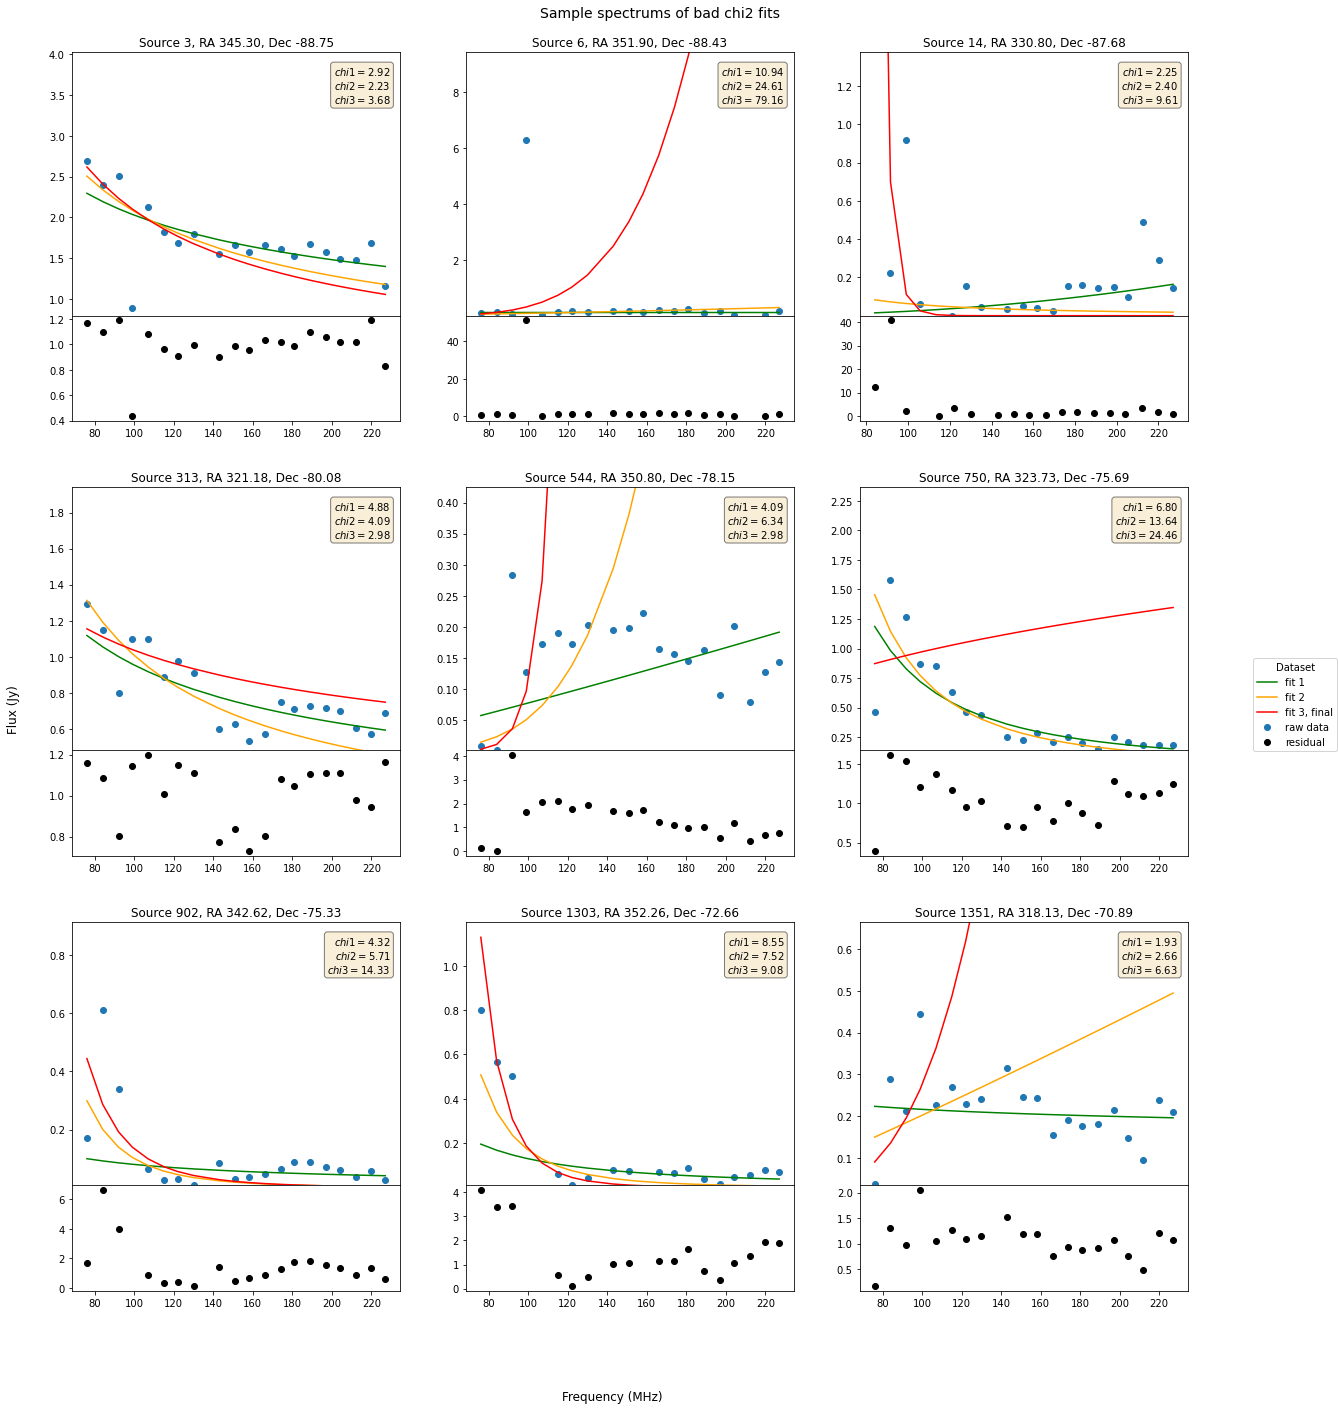

In [415]:
plotFits(gleam_catalog,source_dict,bad_chi2,savefig=False,Nsources=9)

You have mixed positional and keyword arguments, some input may be discarded.


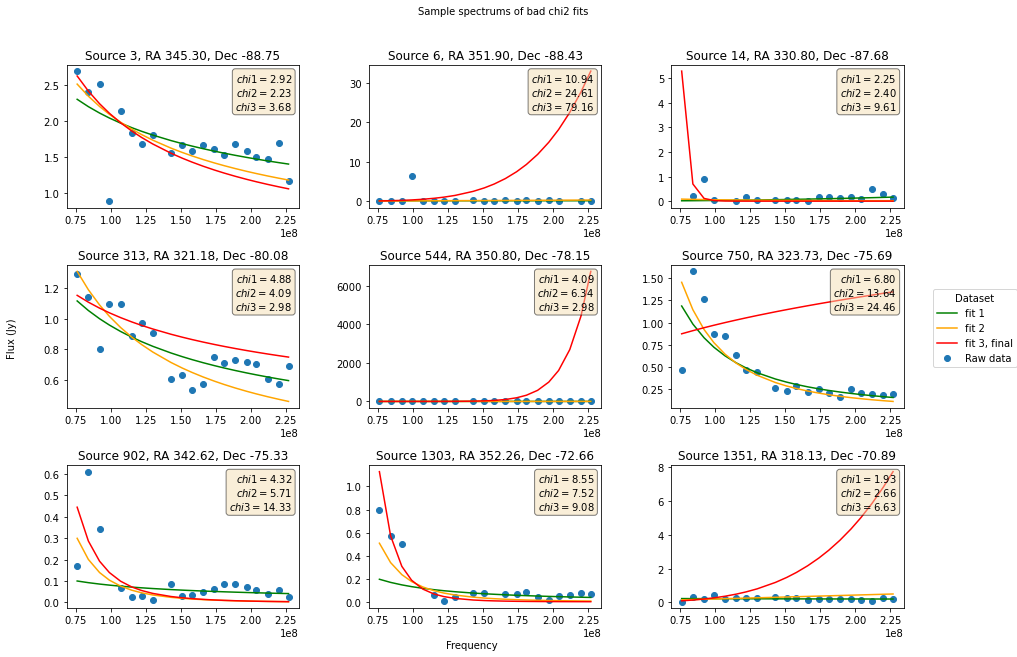

In [294]:
fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.3)

axs = axs.ravel()

for i in range(9):
    
    source_num = bad_chi2[i][0]
    
    #data plots
    axs[i].plot(source_dict[bad_chi2[i][0]]['freqs'], bad_chi2[i][1], label = "first fit", color = "green")
    axs[i].plot(source_dict[bad_chi2[i][0]]['freqs'], bad_chi2[i][2], label = "second fit", color = "orange")
    axs[i].plot(source_dict[bad_chi2[i][0]]['freqs'], source_dict[bad_chi2[i][0]]['all_freqs_fitted_data'], label = "final fit", color = 'red')
    axs[i].scatter(source_dict[bad_chi2[i][0]]['freqs'], gleam_catalog.stokes.value[0,:,source_num], label = "Raw data")
    axs[i].set_title("Source "+ str(source_num) + ", RA " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['ra']) + ", Dec " + "{:.2f}".format(source_dict[bad_chi2[i][0]]['dec']))
    
    #floating box
    textstr = '\n'.join((
    r'$chi1=%.2f$' % (bad_chi2[i][4]),
    r'$chi2=%.2f$' % (bad_chi2[i][5]),
    r'$chi3=%.2f$' % (bad_chi2[i][6])))
    
    props = dict(boxstyle = "round", facecolor = "wheat", alpha = .5)
    axs[i].text(0.97, 0.95, textstr, horizontalalignment='right', verticalalignment='top', transform=axs[i].transAxes, bbox = props)
    
fig.legend(axs,     # The line objects
           labels=["fit 1", "fit 2", "fit 3, final", "Raw data"],   # The labels for each line
           loc="center right",   # Position of legend
           borderaxespad=0.1,    # Small spacing around legend box
           title="Dataset"  # Title for the legend
           )
fig.text(0.5, 0.07, 'Frequency', ha='center')
fig.text(0.07, 0.5, 'Flux (Jy)', va='center', rotation='vertical')
fig.text(.45, .95, "Sample spectrums of bad chi2 fits")
fig.savefig("/Users/Kiana1/uwradcos/plots/bad_chi2_spectrums.png")

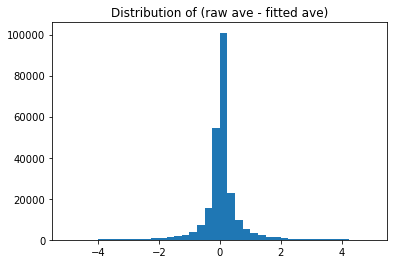

In [109]:
ave_diff = [a_i - b_i for a_i, b_i in zip(averages, fit_averages) if -5 < a_i - b_i < 5]
plt.hist(ave_diff, bins=40)
plt.title("Distribution of (raw ave - fitted ave)")
plt.savefig("/Users/Kiana1/uwradcos/plots/stokes_ave_diff_hist.png")

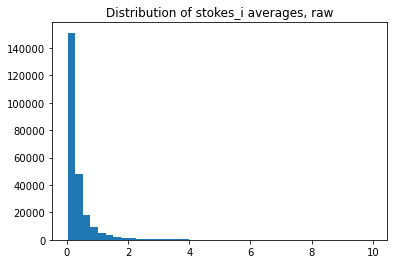

In [110]:
averages2 = [x for x in averages if x <= 10]
plt.hist(averages2, bins=40)
plt.title("Distribution of stokes_i averages, raw")
plt.savefig("/Users/Kiana1/uwradcos/plots/raw_stokes_ave_hist.png")

In [177]:
inx = 19973
print(source_dict[inx]['coefficients'][1])
print(gleam_spectral_index.spectral_index[inx])
plt.scatter(source_dict[inx]["freqs"], source_dict[inx]['all_freqs_fitted_data'])
plt.scatter(gleam_catalog.freq_array.value, gleam_catalog.stokes.value[0,:,inx])

KeyError: 19973

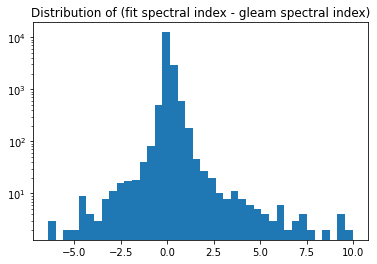

In [187]:
fit_spectral_index = []
for i in np.arange(19972):
    fit_spectral_index.append(source_dict[i]['coefficients'][1])

spectral_index_diff = [a_i - b_i for a_i, b_i in zip(fit_spectral_index, gleam_spectral_index.spectral_index[0:19972]) if -10 < a_i - b_i < 10]
plt.hist(spectral_index_diff, bins=40)
plt.title("Distribution of (fit spectral index - gleam spectral index)")
plt.yscale('log')
plt.savefig("/Users/Kiana1/uwradcos/plots/spectral_indx_diff_hist.png")


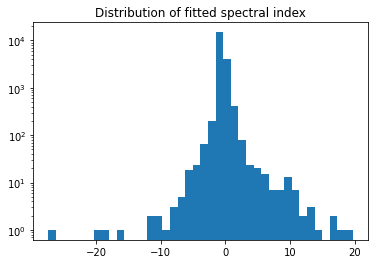

In [192]:
fit_spectral_index = []
for i in np.arange(19972):
    fit_spectral_index.append(source_dict[i]['coefficients'][1])

spectral_index_diff = [a_i for a_i in fit_spectral_index]
plt.hist(spectral_index_diff, bins=40)
plt.title("Distribution of fitted spectral index")
plt.yscale('log')
#plt.savefig("/Users/Kiana1/uwradcos/plots/spectral_indx_diff_hist.png")

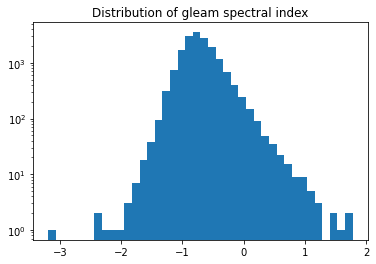

In [193]:
fit_spectral_index = []
for i in np.arange(19972):
    fit_spectral_index.append(source_dict[i]['coefficients'][1])

spectral_index_diff = [b_i for b_i in gleam_spectral_index.spectral_index[0:19972]]
plt.hist(spectral_index_diff, bins=40)
plt.title("Distribution of gleam spectral index")
plt.yscale('log')
#plt.savefig("/Users/Kiana1/uwradcos/plots/spectral_indx_diff_hist.png")

In [267]:
print(source_dict[0])
print(gleam_spectral_index.spectral_index[0])

{'ra': 357.914368, 'dec': -89.687309, 'coefficients': array([ 6.45707627, -0.85964027]), 'chi2_residual': 1.5014617455612138, 'all_freqs_fitted_data': array([0.48129518, 0.44161788, 0.40839791, 0.38344779, 0.35866962,
       0.33711321, 0.3204171 , 0.30339176, 0.2795252 , 0.26674622,
       0.25655497, 0.24588968, 0.23613929, 0.22826703, 0.21993603,
       0.212236  , 0.2059603 , 0.19926115, 0.19301619, 0.18788837]), 'freqs': array([7.60e+07, 8.40e+07, 9.20e+07, 9.90e+07, 1.07e+08, 1.15e+08,
       1.22e+08, 1.30e+08, 1.43e+08, 1.51e+08, 1.58e+08, 1.66e+08,
       1.74e+08, 1.81e+08, 1.89e+08, 1.97e+08, 2.04e+08, 2.12e+08,
       2.20e+08, 2.27e+08]), 'freqs_used_for_fit': array([7.60e+07, 8.40e+07, 9.20e+07, 9.90e+07, 1.07e+08, 1.15e+08,
       1.22e+08, 1.30e+08, 1.43e+08, 1.51e+08, 1.58e+08, 1.66e+08,
       1.74e+08, 1.81e+08, 1.89e+08, 1.97e+08, 2.04e+08, 2.12e+08,
       2.20e+08, 2.27e+08]), 'data_used_for_fit': array([0.528997, 0.509285, 0.423489, 0.438262, 0.326553, 0.291348,


In [83]:
chi2_test = []
chi2_test[:] = [x for x in chi2_residual_all if x <= 1.93]

In [84]:
len(chi2_test)


241592

In [26]:
t = Table([np.array(nan_sources), np.array(nan_coords), np.array(nan_data), np.array(nan_error)], names = ('source', 'coordinates', 'stokes_i_data', 'stokes_i_error'))
t.write('/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/misc/nan_error_sources.fits', format='fits')

In [24]:
hdu = fits.PrimaryHDU()
hdu.data = t

KeyError: 'void2752'

In [23]:
test = fits.open('/Users/Kiana1/uwradcos/GleamPlusFullSpectrum/misc/nan_error_sources.fits')
test.header

AttributeError: 'HDUList' object has no attribute 'header'

In [104]:
print("first chi2 < 1.93: ", len([x for x in first_chi2 if x < 1.93]))
print("first chi2 >= 1.93: ", len([x for x in first_chi2 if x >= 1.93]))
print("second chi2 < 1.93: ", len([x for x in second_chi2 if x < 1.93]))
print("second chi2 >= 1.93: ", len([x for x in second_chi2 if x >= 1.93]))
print("third chi2 < 1.93: ", len([x for x in third_chi2 if x < 1.93]))
print("third chi2 >= 1.93: ", len([x for x in third_chi2 if x >= 1.93]))
print("final chi2 < 1.93: ", len([x for x in final_chi2 if x < 1.93]))
print("final chi2 >= 1.93: ", len([x for x in final_chi2 if x >= 1.93]))

first chi2 < 1.93:  283565
first chi2 >= 1.93:  23489
second chi2 < 1.93:  13732
second chi2 >= 1.93:  9754
third chi2 < 1.93:  4819
third chi2 >= 1.93:  4935
final chi2 < 1.93:  2
final chi2 >= 1.93:  1


Plotting Data

Text(0.5, 1.0, 'Residual Chi2 <20, all freqs')

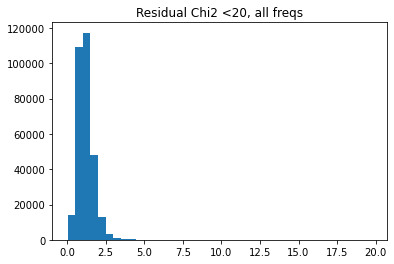

In [79]:
# Distribution of chi2 values after fitting on all freqs
first_chi2[:] = [x for x in first_chi2 if x <= 20]
plt.hist(first_chi2, bins = 40)
plt.title("Residual Chi2 <20, all freqs")

Text(0.5, 1.0, 'Residual Chi2 <20, bottom half freqs')

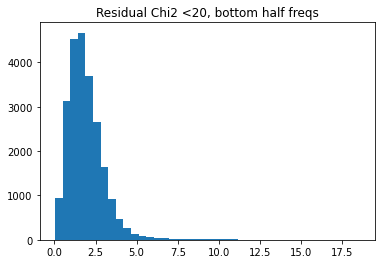

In [81]:
# Distribution of chi2 values after fitting on bottom half of freqs
second_chi2[:] = [x for x in second_chi2 if x <= 20]
plt.hist(second_chi2, bins = 40)
plt.title("Residual Chi2 <20, bottom half freqs")

Text(0.5, 1.0, 'Residual Chi2, bottom quarter freqs')

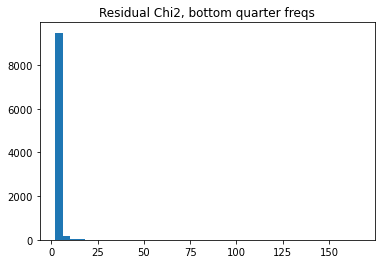

In [96]:
# Distribution of chi2 values after fitting on bottom half of freqs
third_chi2[:] = [x for x in third_chi2]# if x <= 20]
plt.hist(third_chi2, bins = 40)
plt.title("Residual Chi2, bottom quarter freqs")

Text(0.5, 1.0, 'Residual Chi2, bottom 4 freqs')

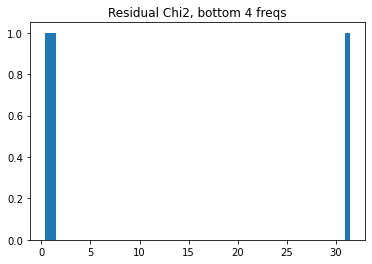

In [84]:
# Distribution of chi2 values after fitting on bottom 4 freqs
final_chi2[:] = [x for x in final_chi2] # if x <= 5000]
plt.hist(final_chi2, bins = 0)
plt.title("Residual Chi2, bottom 4 freqs")

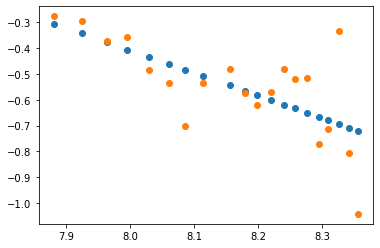

In [415]:
plt.scatter(freqs_log, fit)
plt.scatter(freqs_log, fit_data_log)

(10,)
(10,)
(10,)


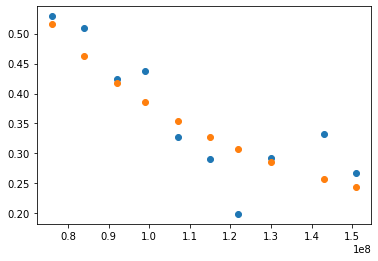

In [604]:
plt.scatter(half_freqs, fit_data_half)
plt.scatter(half_freqs, fitted_data)

In [ ]:
#plot all ruby's catalog points
fig = go.Figure(data=go.Scatter(
    x = ruby.ra,
    y = ruby.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=ruby.stokes_i, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/ruby_data.html')

#plot all ruby's catalog points that are NOT in GLEAM
fig = go.Figure(data=go.Scatter(
    x = ruby_not_in_gleam.ra,
    y = ruby_not_in_gleam.dec,
    mode='markers',
    marker=dict(
        size=2,
        color=ruby_not_in_gleam.stokes_i, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))

fig.write_html('./plots/only_ruby_data.html')

In [286]:
# Let's check out the objs with bad chi2 residuals
bad_chi_objs = gleam_catalog.stokes.value[0, 0, bad_chi2]
bad_chi_ra = gleam_catalog.ra.value[bad_chi2]
bad_chi_dec = gleam_catalog.dec.value[bad_chi2]

In [288]:
#plot gleam points that have high chi2
fig = go.Figure(data=go.Scatter(
    x = bad_chi_ra,
    y = bad_chi_dec,
    mode='markers',
    marker=dict(
        size=2,
        color=bad_chi_objs, #set color equal to a variable
        colorscale='Viridis', # one of plotly colorscales
        showscale=True
    )
))
fig.write_image('/Users/Kiana1/uwradcos/plots/gleam_high_chi2.png')
#fig.write_html('/Users/Kiana1/uwradcos/plots/gleam_high_chi2.html')